# 2018 Yellow Taxi Trip Data Analysis

- Importing python library
- Read taxi-sample and shape files
- Data cleaning (removing null values, trip duration 0 etc.)
- Insights on different attributes

In [1]:
import pandas as pd
import numpy as np
import time
import shapefile
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import seaborn as sns
import math

### Loading taxi-sample data

In [2]:
startTime = time.time()
taxiSample = pd.read_csv("data/taxi-sample.csv")
taxiSample[105:110]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
105,2,03/12/2019 11:12:48 PM,03/12/2019 11:23:38 PM,1,1.10,1,N,137,113,1,8.5,0.0,0.5,1.86,0.0,0.3,11.16
106,2,03/07/2019 06:25:03 AM,03/07/2019 03:25:31 PM,1,8.66,1,N,163,54,1,38.0,0.0,0.5,7.76,0.0,0.3,46.56
107,2,03/04/2019 12:35:59 PM,03/04/2019 01:07:03 PM,2,5.52,1,N,50,179,1,23.0,0.0,0.5,0.00,0.0,0.3,23.80
108,2,03/04/2019 12:13:56 AM,03/04/2019 12:32:39 AM,5,11.94,1,N,70,265,2,32.5,0.0,0.5,0.00,0.0,0.3,33.30
109,2,03/03/2019 03:27:20 AM,03/03/2019 12:01:14 PM,1,6.37,1,N,170,13,1,27.0,0.0,0.5,4.50,0.0,0.3,32.30


### Update datetime column to 24 hour format and adding columns for hour, week, month etc.

In [3]:
%%time
taxiSample['tpep_pickup_datetime'] = pd.to_datetime(taxiSample['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
taxiSample['tpep_dropoff_datetime'] = pd.to_datetime(taxiSample['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

CPU times: user 6.85 s, sys: 13.1 ms, total: 6.87 s
Wall time: 6.86 s


In [4]:
taxiSample["pickup_date"] = taxiSample.tpep_pickup_datetime.dt.day
taxiSample["pickup_dayofweek"] = taxiSample.tpep_pickup_datetime.dt.weekday
taxiSample["pickup_weekday"] = taxiSample.tpep_pickup_datetime.dt.weekday_name
taxiSample["pickup_hour"] = taxiSample.tpep_pickup_datetime.dt.hour
taxiSample["pickup_month"] = taxiSample.tpep_pickup_datetime.dt.month
taxiSample["pickup_year"] = taxiSample.tpep_pickup_datetime.dt.year

In [5]:
taxiSample["dropoff_date"] = taxiSample.tpep_dropoff_datetime.dt.day
taxiSample["dropoff_weekday"] = taxiSample.tpep_dropoff_datetime.dt.weekday_name
taxiSample["dropoff_hour"] = taxiSample.tpep_dropoff_datetime.dt.hour
taxiSample["dropoff_month"] = taxiSample.tpep_dropoff_datetime.dt.month
taxiSample["dropoff_year"] = taxiSample.tpep_dropoff_datetime.dt.year

In [6]:
print(taxiSample.shape)
taxiSample[105:110]

(1048576, 28)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pickup_dayofweek,pickup_weekday,pickup_hour,pickup_month,pickup_year,dropoff_date,dropoff_weekday,dropoff_hour,dropoff_month,dropoff_year
105,2,2019-03-12 23:12:48,2019-03-12 23:23:38,1,1.10,1,N,137,113,1,...,1,Tuesday,23,3,2019,12,Tuesday,23,3,2019
106,2,2019-03-07 06:25:03,2019-03-07 15:25:31,1,8.66,1,N,163,54,1,...,3,Thursday,6,3,2019,7,Thursday,15,3,2019
107,2,2019-03-04 12:35:59,2019-03-04 13:07:03,2,5.52,1,N,50,179,1,...,0,Monday,12,3,2019,4,Monday,13,3,2019
108,2,2019-03-04 00:13:56,2019-03-04 00:32:39,5,11.94,1,N,70,265,2,...,0,Monday,0,3,2019,4,Monday,0,3,2019
109,2,2019-03-03 03:27:20,2019-03-03 12:01:14,1,6.37,1,N,170,13,1,...,6,Sunday,3,3,2019,3,Sunday,12,3,2019


### Loading shape file

In [7]:
taxiZonesShape = shapefile.Reader("data/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in taxiZonesShape.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = taxiZonesShape.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

### Methods for displaying the map

In [8]:
def get_lat_lon(taxiZones):
    content = []
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [9]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [10]:
def draw_region_map(ax, taxiZones, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_x = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    reg_y = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values())))
        cm=plt.get_cmap('Reds')
    
    ax.set_facecolor(ocean)
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center',
                     verticalalignment='center', bbox=dict(facecolor='black', alpha=0.5),
                     color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000),
                     horizontalalignment='center', verticalalignment='center',
                     bbox=dict(facecolor='black', alpha=0.7), color="white", fontsize=12)       

    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [11]:
def draw_zone_map(ax, taxiZones, heat={}, text=[], arrows=[]):
    continent = [180/256, 50/256, 50/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values()))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.7), color="white", fontsize=8,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [12]:
taxiZone = pd.DataFrame(shp_attr).join(get_lat_lon(taxiZonesShape).set_index("LocationID"), on="LocationID")
zone_dic = dict(zip(taxiZone.LocationID, taxiZone.zone))
borough_dic = dict(zip(taxiZone.LocationID, taxiZone.borough))
zones = taxiZone['zone'].unique()
boroughs = taxiZone['borough'].unique()
temp = dict(enumerate(boroughs.flatten(), 1))
reg_list = dict([(value, key) for key, value in temp.items()])
print(reg_list)
taxiZone.head()

{'EWR': 1, 'Queens': 2, 'Bronx': 3, 'Manhattan': 4, 'Staten Island': 5, 'Brooklyn': 6}


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


### Show the boroughs and zones of New York City

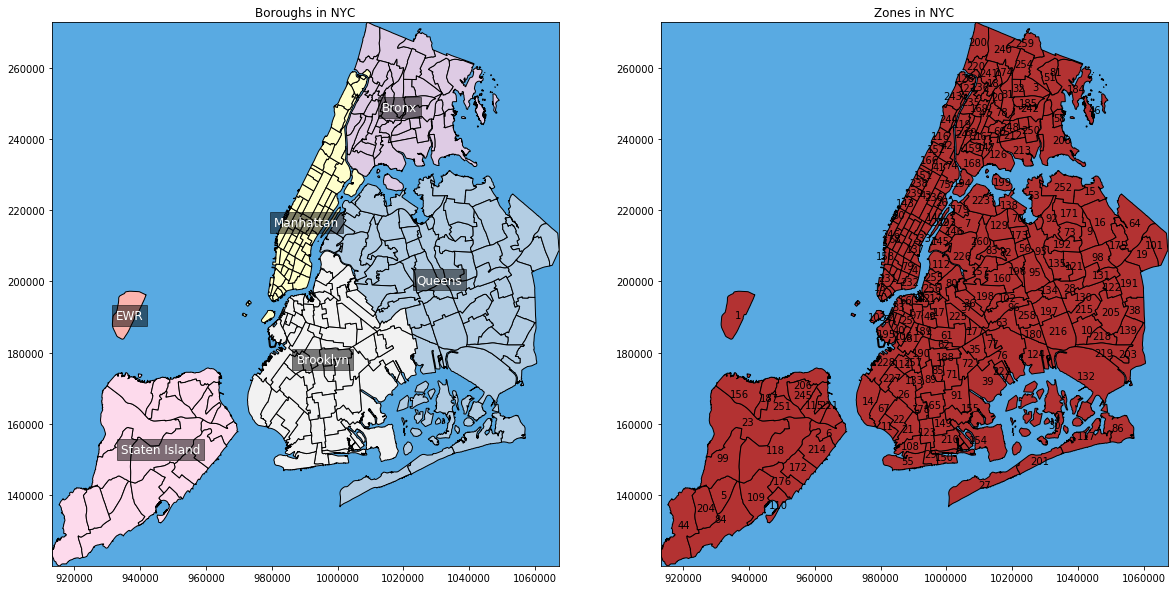

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, taxiZonesShape)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, taxiZonesShape)

## Data Cleaning

### Checking if there is any null value in the dataset

In [14]:
taxiSample.isnull().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count          False
trip_distance            False
RatecodeID               False
store_and_fwd_flag       False
PULocationID             False
DOLocationID             False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
pickup_date              False
pickup_dayofweek         False
pickup_weekday           False
pickup_hour              False
pickup_month             False
pickup_year              False
dropoff_date             False
dropoff_weekday          False
dropoff_hour             False
dropoff_month            False
dropoff_year             False
dtype: bool

### Removing rows with trip distance 0 or less

In [15]:
trip_dist = taxiSample[taxiSample.trip_distance <= 0.0]
trip_dist.shape

(8463, 28)

In [16]:
taxiSample = taxiSample[taxiSample.trip_distance > 0.0]
taxiSample.shape

(1040113, 28)

### Removing rows with passenger count 0 or less

In [17]:
pass_count = taxiSample[taxiSample.passenger_count <= 0]
pass_count.shape

(15039, 28)

In [18]:
taxiSample = taxiSample[taxiSample.passenger_count > 0]
taxiSample.shape

(1025074, 28)

### Removing duplicate rows

In [19]:
duplicate = taxiSample[taxiSample.duplicated()]
duplicate.shape

(21, 28)

In [20]:
taxiSample.drop_duplicates(keep='first', inplace=True)
taxiSample.shape

(1025053, 28)

### Removing rows with same pickup and dropoff time

In [21]:
same_pick_drop = taxiSample[taxiSample.tpep_pickup_datetime==taxiSample.tpep_dropoff_datetime]
same_pick_drop.shape

(46, 28)

In [22]:
taxiSample = taxiSample[taxiSample.tpep_pickup_datetime!=taxiSample.tpep_dropoff_datetime]
taxiSample.shape

(1025007, 28)

### Removing rows with future dates

In [23]:
print("Train dataset start date: ", min(taxiSample["tpep_pickup_datetime"]))
print("Train dataset end date: ", max(taxiSample["tpep_dropoff_datetime"]))

Train dataset start date:  2018-12-27 00:05:14
Train dataset end date:  2084-11-04 12:47:41


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x='pickup_year', data=taxiSample, ax=ax[0])
sns.countplot(x='dropoff_year', data=taxiSample, ax=ax[1])
plt.show()

In [ ]:
taxiSample.groupby('pickup_year')['pickup_year'].count()

#### We are assuming limit for date is: "2019-06-30 23:59:59" and remove all the future dates

In [ ]:
taxiSample = taxiSample[taxiSample.tpep_pickup_datetime<="2019-06-30 23:59:59"]
taxiSample.shape

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x='pickup_year', data=taxiSample, ax=ax[0])
sns.countplot(x='dropoff_year', data=taxiSample, ax=ax[1])
plt.show()

### Removing rows that have RatecodeID>6

In [ ]:
ratecode_count = taxiSample.groupby('RatecodeID')['RatecodeID'].count()
ratecode_count

In [ ]:
taxiSample = taxiSample[taxiSample.RatecodeID<=6]
taxiSample.shape

### Checking amounts for negative or zero values

In [ ]:
taxiSample[taxiSample.fare_amount<=0.0].shape

In [ ]:
taxiSample[taxiSample.tip_amount<0.0].shape

In [ ]:
taxiSample[taxiSample.tolls_amount<0.0].shape

In [ ]:
taxiSample[taxiSample.total_amount<=0.0].shape

In [ ]:
taxiSample[taxiSample.extra<0.0].shape

In [ ]:
taxiSample[taxiSample.mta_tax<0.0].shape

In [ ]:
taxiSample[taxiSample.improvement_surcharge<0.0].shape

In [ ]:
taxiSample = taxiSample[taxiSample.fare_amount>0.0]
taxiSample = taxiSample[taxiSample.tip_amount>=0.0]
taxiSample = taxiSample[taxiSample.tolls_amount>=0.0]
taxiSample = taxiSample[taxiSample.total_amount>0.0]
taxiSample = taxiSample[taxiSample.extra>=0.0]
taxiSample = taxiSample[taxiSample.mta_tax>=0.0]
taxiSample = taxiSample[taxiSample.improvement_surcharge>=0.0]
taxiSample.shape

### Removing rows that has LocationID > 263 or < 1, as we don't have shape for those zones

In [ ]:
taxiSample[taxiSample.PULocationID>263].shape

In [ ]:
taxiSample[taxiSample.DOLocationID>263].shape

In [ ]:
taxiSample = taxiSample[taxiSample.PULocationID<=263]

In [ ]:
taxiSample = taxiSample[taxiSample.DOLocationID<=263]

# Insights on different attributes

## Vendor

### Which vendor is most popular overall?

In [ ]:
sns.countplot(x="VendorID", data=taxiSample)

In [ ]:
taxiSample.groupby('VendorID')['VendorID'].count()

### Which Vendor is popular in each region?

In [ ]:
result = taxiSample.groupby(['VendorID','PULocationID'])['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'})
result = result.merge(taxiZone, on='LocationID', how='left')
groupResult = result.groupby(['borough','VendorID'])['count'].sum().reset_index(name='count')
print(groupResult)
vendor1 = groupResult[groupResult.VendorID==1]['count']
vendor2 = groupResult[groupResult.VendorID==2]['count']
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(groupResult['borough'].unique(), vendor1, label = "Vendor 1")
ax.bar(groupResult['borough'].unique(), vendor2, bottom=vendor1, label = "Vendor 2")
ax.legend()

## Passenger

### What is the most frequent passenger count?

In [ ]:
sns.countplot(x="passenger_count", data=taxiSample)

In [ ]:
taxiSample.groupby('passenger_count')['passenger_count'].count()

## Store and Forward trip

### What is the percentage of store and forward trip?

In [ ]:
sns.countplot(x="store_and_fwd_flag", data=taxiSample)

In [ ]:
taxiSample.groupby('store_and_fwd_flag')['store_and_fwd_flag'].count()

In [ ]:
temp_flag = taxiSample[taxiSample.store_and_fwd_flag=='N']
(temp_flag.shape[0]*100) / taxiSample.shape[0]  # percentage of record that are N

### Which region has the most store and forward trip?

In [ ]:
flagCount = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    flagCount[borough] = totalRideBorough[totalRideBorough.store_and_fwd_flag=='Y']['store_and_fwd_flag'].count()
print(flagCount)
plt.bar(range(len(flagCount)), list(flagCount.values()), align='center')
plt.xticks(range(len(flagCount)), list(flagCount.keys()), rotation=45)

plt.show()

## Payment method

### What is the most popular payment method?

payment_type is a numeric code signifying how the passenger paid for the trip:

* 1=Credit card
* 2=Cash
* 3=No charge
* 4=Dispute

In [ ]:
sns.countplot(x="payment_type", data=taxiSample)

In [ ]:
taxiSample.groupby('payment_type')['payment_type'].count()

### Which Payment Type is popular in each region?

In [ ]:
result = taxiSample.groupby(['payment_type','PULocationID'])['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'})
result = result.merge(taxiZone, on='LocationID', how='left')
groupResult = result.groupby(['borough','payment_type'])['count'].sum().reset_index(name='count')
print(groupResult)
payment1 = groupResult[groupResult.payment_type==1]['count']
payment2 = groupResult[groupResult.payment_type==2]['count']
payment3 = groupResult[groupResult.payment_type==3]['count']
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(groupResult['borough'].unique(), payment1, label = "Credit Card")
ax.bar(groupResult['borough'].unique(), payment2, label = "Cash")
ax.bar(groupResult['borough'].unique(), payment3, label = "No Charge")
ax.legend()

* We can see that EWR and Shaten Island has no Dispute payment type

## Fare and Tip amount

### What is the rate of tip?

In [ ]:
no_tip = taxiSample[taxiSample.tip_amount==0]
no_tip.shape

In [ ]:
tip = taxiSample[taxiSample.tip_amount>0]
tip.shape

In [ ]:
(tip.shape[0]*100) / (no_tip.shape[0] + tip.shape[0])  # percentage of passenger that tips

### What is the relation between fareAmount and tip?

In [ ]:
taxiSample[taxiSample.fare_amount<80].fare_amount.hist(bins=50, figsize=(14,3))
plt.xlabel('fare $USD')
plt.ylabel('count')
plt.title('Fare amount');

In [ ]:
taxiSample[taxiSample.tip_amount<15].tip_amount.hist(bins=30, figsize=(14,3))
plt.xlabel('tip $USD')
plt.ylabel('count')
plt.title('Tip amount');

In [ ]:
fare_tip = taxiSample[['fare_amount','tip_amount']]
plt.figure(figsize=(10,5))
plt.plot(fare_tip)
plt.title('Relationship between fare and tip for all trips')
plt.xlabel('count')
plt.ylabel('amount (fare, tip)')
plt.show()

## Tolls amount

### Which region has the most trips that includes a bridge? i.e. toll~bridge

In [ ]:
tollsCount = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    tollsCount[borough] = totalRideBorough[totalRideBorough.tolls_amount>0]['tolls_amount'].count()
print(tollsCount)
plt.bar(range(len(tollsCount)), list(tollsCount.values()), align='center')
plt.xticks(range(len(tollsCount)), list(tollsCount.keys()), rotation=45)
plt.xlabel('count')
plt.show()

## Pickup and Dropoff time

### Which day of the week has most pickup/dropoff?

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_weekday", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_weekday", data=taxiSample, ax=ax[1])
plt.show()

### Which time of the day has most pickup/dropoff?

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_hour", data=taxiSample, ax=ax[1])
plt.show()

### Which month has the most pickup/dropoff?

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_month", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_month", data=taxiSample, ax=ax[1])
plt.show()

### What is the busiest hour in each borough of New York City?

In [ ]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='pickup_hour', data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

### What is the busiest day of a week in each borough of New York City?

In [ ]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='pickup_weekday', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

### Which day is busiest in december in each region?

#### Based on pickup location id

In [ ]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='pickup_date', data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

#### Based on dropoff location id

In [ ]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'DOLocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='DOLocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='dropoff_date', data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

### Show the number of trip vs day vs hour graph, so that we can easily know which time of a day is the busiest hour

In [ ]:
result = taxiSample.groupby(['pickup_dayofweek','pickup_hour'])['PULocationID'].count().reset_index(name='count')
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
x = result['pickup_dayofweek']
y = result['pickup_hour']
z = result['count']
ax.scatter(x, y, z, s=40, c='blue', marker='x')
plt.xlabel("Weekday")
plt.ylabel("Hour of the day")
plt.show()

## Trip duration

In [ ]:
taxiSample['trip_duration'] = (taxiSample.tpep_dropoff_datetime - taxiSample.tpep_pickup_datetime).dt.total_seconds()

In [ ]:
taxiSample.trip_duration.describe()

### Which day has the most trip duration?

In [ ]:
df_train_agg = taxiSample.groupby('pickup_weekday')['trip_duration'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.pointplot(df_train_agg.pickup_weekday, df_train_agg.trip_duration)
plt.show()

### Which time has the most trip duration?

In [ ]:
df_train_agg = taxiSample.groupby('pickup_hour')['trip_duration'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.pointplot(df_train_agg.pickup_hour, df_train_agg.trip_duration)
plt.show()

## Trip distance

In [ ]:
taxiSample['trip_distance'].describe()

### What is the number of short and long distance trip? (i.e. short distance<20)

In [ ]:
short_distance = taxiSample[taxiSample.trip_distance<20.0]
long_distance = taxiSample[taxiSample.trip_distance>=20.0]
print(short_distance.shape)
print(long_distance.shape)

### Which time of the day has the most short distance trip?

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=short_distance, ax=ax[0])
sns.countplot(x="dropoff_hour", data=short_distance, ax=ax[1])
plt.show()

### Which time of the day has the most long distance trip?

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=long_distance, ax=ax[0])
sns.countplot(x="dropoff_hour", data=long_distance, ax=ax[1])
plt.show()

## Traffic condition

### What is the average trip distance of the day?

In [ ]:
traffic = taxiSample.groupby('pickup_hour')['trip_distance','trip_duration'].mean().reset_index()
ax = traffic.plot(x='pickup_hour', y='trip_distance', kind='line', style="-o", figsize=(15,5))
plt.show()

### What is the average trip duration of the day?

In [ ]:
ax = traffic.plot(x='pickup_hour', y=['trip_duration'], kind='line', style="-o", figsize=(15,5))
plt.show()

### What is the traffic condition(trip duration/trip distance) of different regions during a day?

In [ ]:
result = taxiSample.groupby(['pickup_hour','PULocationID'])['trip_distance','trip_duration'].sum().reset_index().rename(columns={'PULocationID':'LocationID'})
result = result.merge(taxiZone, on='LocationID', how='left')
groupResult = result.groupby(['borough','pickup_hour'])['trip_distance','trip_duration'].sum().reset_index()
groupResult['traffic'] = result['trip_duration']/result['trip_distance']
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    ax = fig.add_subplot(3, 2, index)
    boroughData = groupResult[groupResult.borough==borough]
    boroughData.plot(x='pickup_hour', y='traffic', ax=ax).set_title(borough)
    index += 1

## Pickup/Dropoff location id

In [ ]:
pu_location = taxiSample.groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location = taxiSample.groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

### Show the top 5 zones with most pickups and dropoffs

In [ ]:
pu_do_location = taxiZone.merge(pu_location, on='LocationID', how='left')
pu_do_location = pu_do_location.merge(do_location, on='LocationID', how='left')
pu_do_location['totalCount'] = pu_do_location['puCount'] + pu_do_location['doCount']
pu_do_location.head()

In [ ]:
puCount = dict(zip(pu_do_location['LocationID'].tolist(), pu_do_location['puCount'].tolist()))
puTop5 = pu_do_location.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCount = dict(zip(pu_do_location['LocationID'].tolist(), pu_do_location['doCount'].tolist()))
doTop5 = pu_do_location.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

#### Top 5 pickup zone

In [ ]:
puTop5

#### Top 5 dropoff zone

In [ ]:
doTop5

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, taxiZonesShape, heat=puCount, text=puTop5.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, taxiZonesShape, heat=doCount, text=doTop5.index.tolist())

### Which region has the most pickups and dropoffs?

In [ ]:
pu_do_region = pu_do_location.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region

In [ ]:
puCount = dict(zip(pu_do_region['borough'].tolist(), pu_do_region['puCount'].tolist()))
doCount = dict(zip(pu_do_region['borough'].tolist(), pu_do_region['doCount'].tolist()))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, taxiZonesShape, heat = puCount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, taxiZonesShape, heat = doCount)

### Which zone has the most pickups/dropoffs for short trips (distance<20) and long trips (distance>=20)

In [ ]:
pu_location_short = taxiSample[taxiSample.trip_distance<20].groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location_short = taxiSample[taxiSample.trip_distance<20].groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

pu_do_location_short = taxiZone.merge(pu_location_short, on='LocationID', how='left')
pu_do_location_short = pu_do_location_short.merge(do_location_short, on='LocationID', how='left')
pu_do_location_short['totalCount'] = pu_do_location_short['puCount'] + pu_do_location_short['doCount']

In [ ]:
pu_location_long = taxiSample[taxiSample.trip_distance>=20].groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location_long = taxiSample[taxiSample.trip_distance>=20].groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

pu_do_location_long = taxiZone.merge(pu_location_long, on='LocationID', how='left')
pu_do_location_long = pu_do_location_long.merge(do_location_long, on='LocationID', how='left')
pu_do_location_long['totalCount'] = pu_do_location_long['puCount'] + pu_do_location_long['doCount']

In [ ]:
puCountShort = dict(zip(pu_do_location_short['LocationID'].tolist(), pu_do_location_short['puCount'].tolist()))
puTop5Short = pu_do_location_short.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCountShort = dict(zip(pu_do_location_short['LocationID'].tolist(), pu_do_location_short['doCount'].tolist()))
doTop5Short = pu_do_location_short.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

#### Top 5 short distance pickup zone

In [ ]:
puTop5Short

#### Top 5 short distance dropoff zone

In [ ]:
doTop5Short

In [ ]:
puCountLong = dict(zip(pu_do_location_long['LocationID'].tolist(), pu_do_location_long['puCount'].tolist()))
puTop5Long = pu_do_location_long.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCountLong = dict(zip(pu_do_location_long['LocationID'].tolist(), pu_do_location_long['doCount'].tolist()))
doTop5Long = pu_do_location_long.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

#### Top 5 long distance pickup zone

In [ ]:
puTop5Long

#### Top 5 long distance dropoff zone

In [ ]:
doTop5Long

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, taxiZonesShape, heat=puCountShort, text=puTop5Short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, taxiZonesShape, heat=puCountLong, text=puTop5Long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, taxiZonesShape, heat=doCountShort, text=doTop5Short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, taxiZonesShape, heat=doCountLong, text=doTop5Long.index.tolist())

### Which region is popular for short trips and long trips?

#### Most popular region for short trips

In [ ]:
pu_do_region_short = pu_do_location_short.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region_short

#### Most popular region for long trips

In [ ]:
pu_do_region_long = pu_do_location_long.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region_long

In [ ]:
totalCountShort = dict(zip(pu_do_region_short['borough'].tolist(), pu_do_region_short['totalCount'].tolist()))
totalCountLong = dict(zip(pu_do_region_long['borough'].tolist(), pu_do_region_long['totalCount'].tolist()))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups/dropoff for short trips")
draw_region_map(ax, taxiZonesShape, heat = totalCountShort)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most pickups/dropoff for long trips")
draw_region_map(ax, taxiZonesShape, heat = totalCountLong)

### Show top 5 inter zone trip

In [ ]:
intraZone = taxiSample[taxiSample.PULocationID == taxiSample.DOLocationID].groupby('PULocationID')['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'}).sort_values(by='count', ascending=False).head(5)
intraZone = intraZone.merge(taxiZone, on='LocationID', how='left')
intraZone

In [ ]:
countList = dict(zip(intraZone['LocationID'].tolist(), intraZone['count'].tolist()))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
ax = plt.subplot(1, 1, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, taxiZonesShape, heat=countList, text=intraZone.LocationID.tolist())

### Show top 5 short distance trip

In [ ]:
top5Short = taxiSample[taxiSample.trip_distance<20].groupby(['PULocationID','DOLocationID'])['PULocationID'].count().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
puZones = []
puBoroughs = []
doZones = []
doBoroughs = []
for i, j in top5Short.iterrows():
    puZones.append(zone_dic[j[0]])
    puBoroughs.append(borough_dic[j[0]])
    doZones.append(zone_dic[j[1]])
    doBoroughs.append(borough_dic[j[1]])
top5Short['Pick-Up-Zone']=puZones
top5Short['Pick-Up-Borough']=puBoroughs
top5Short['Drop-Off-Zone']=doZones
top5Short['Drop-Off-Borough']=doBoroughs
top5Short

### Show top 5 long distance trip

In [ ]:
top5Long = taxiSample[taxiSample.trip_distance>=20].groupby(['PULocationID','DOLocationID'])['PULocationID'].count().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
puZones = []
puBoroughs = []
doZones = []
doBoroughs = []
for i, j in top5Long.iterrows():
    puZones.append(zone_dic[j[0]])
    puBoroughs.append(borough_dic[j[0]])
    doZones.append(zone_dic[j[1]])
    doBoroughs.append(borough_dic[j[1]])
top5Long['Pick-Up-Zone']=puZones
top5Long['Pick-Up-Borough']=puBoroughs
top5Long['Drop-Off-Zone']=doZones
top5Long['Drop-Off-Borough']=doBoroughs
top5Long

### Which region is the most expensive? (totalCost/totalDistance)

In [ ]:
expenseRatio = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    expenseRatio[borough]=totalRideBorough['total_amount'].sum()/totalRideBorough['trip_duration'].sum()
    
plt.bar(range(len(expenseRatio)), list(expenseRatio.values()), align='center')
plt.xticks(range(len(expenseRatio)), list(expenseRatio.keys()), rotation=45)

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12))
ax = plt.subplot(1, 1, 1)
ax.set_title("Most expensive boroughs")
draw_region_map(ax, taxiZonesShape, heat = expenseRatio)

### Which region has the most traffic? (tripDuration/tripDistance)

In [ ]:
trafficRatio = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    trafficRatio[borough]=totalRideBorough['trip_duration'].sum()/totalRideBorough['trip_distance'].sum()
    
plt.bar(range(len(trafficRatio)), list(trafficRatio.values()), align='center')
plt.xticks(range(len(trafficRatio)), list(trafficRatio.keys()), rotation=45)

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12))
ax = plt.subplot(1, 1, 1)
ax.set_title("Most traffic boroughs")
draw_region_map(ax, taxiZonesShape, heat = trafficRatio)

In [ ]:
print("It took %s seconds to process" % (time.time() - startTime))